In [5]:
# Import necessary libraries
# =====================================================================
import os

# Configurar el nivel de logging para mostrar solo errores
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf
import pandas as pd

# Import src code
from src.model.build_unet import build_unet
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize
from src.model.overfitting_test import *
from src.data.create_dataset import dataset_tf
from src.data.path_loader import PathLoader

In [6]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 32
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 128
EPOCHS = 100
T = int(config_hp["T"])  # number of diffusion steps
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

# 1. Dataset

In [8]:
# Load csv data
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

# Show the df
df

,name,pokedex_id,type1,type2,image_fn
0,Bulbasaur,1,Grass,Poison,['1']
1,Ivysaur,2,Grass,Poison,['2']
2,Venusaur,3,Grass,Poison,['3']
3,Venusaur Gmax,3,Grass,Poison,['3_g']
4,Venusaur Mega,3,Grass,Poison,['3_2']
...,...,...,...,...,...
1113,Glastrier,896,Ice,NaN,['896']
1114,Spectrier,897,Ghost,NaN,['897']
1115,Calyrex,898,Psychic,Grass,['898_1']
1116,Calyrex Ice Rider,898,Psychic,Ice,['898_2']


- The shape of the dataset is: (128, 32, 32, 3) => batch_size: 128, height: 32, width: 32, channels: 3
- The shape of the dataset labels is: (128, 18) => batch_size: 128, number of labels: 18


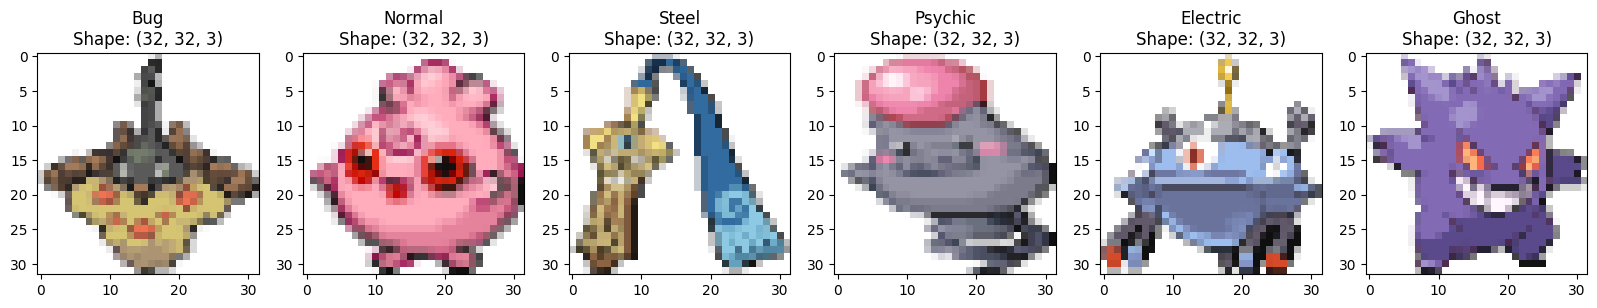

In [9]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    image_paths=PathLoader.get_image_paths(f"{DATA_PATH}/interim/image_paths.json"),
    df=df,
    img_size=32,
    batch_size=128,
    save=False,
    save_path=dataset_path,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

In [38]:
for img, label in poke_dataset.take(1):
    print(label)
    label_test = label

tf.Tensor(
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(128, 18), dtype=float32)


In [18]:
label_test

# mask out the label randomly
mask = np.random.binomial(1, 0.5, label_test.shape).astype("float32")
label_test2 = label_test * mask

label_test2

<tf.Tensor: shape=(128, 18), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [63]:
input_label = (
    tf.random.uniform(shape=[tf.shape(label_test)[0], 1], minval=0, maxval=1)
    * label_test
)

# context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
# c = c * context_mask.unsqueeze(-1)

input_label

<tf.Tensor: shape=(128, 18), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.10518587],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.32913196, 0.        ,
        0.        ],
       ...,
       [0.62638247, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [138]:
tf.shape(c)[0:1]

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([4], dtype=int32)>

In [139]:
# Asumiendo que c es un tensor de TensorFlow definido previamente y que device es el dispositivo deseado
c_tf = tf.constant(
    [
        [1, 0, 0],  # Pokémon de tipo Agua
        [0, 1, 0],  # Pokémon de tipo Fuego
        [1, 0, 0],  # Pokémon de tipo Agua
        [0, 0, 1],  # Pokémon de tipo Planta
    ]
)

# Crear una máscara de contexto usando una distribución Bernoulli
context_mask_tf = tf.random.uniform(tf.shape(c_tf)[0:1]) < 0.9
# Cambiar la forma de context_mask y aplicarla a c
context_mask_tf = tf.reshape(context_mask_tf, [-1, 1])

c_masked_tf = c_tf * tf.cast(context_mask_tf, c_tf.dtype)

print(c_tf)
print(context_mask_tf)
print(c_masked_tf)

tf.Tensor(
[[1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]], shape=(4, 3), dtype=int32)
tf.Tensor(
[[ True]
 [ True]
 [ True]
 [ True]], shape=(4, 1), dtype=bool)
tf.Tensor(
[[1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]], shape=(4, 3), dtype=int32)


In [18]:
import tensorflow as tf

# Creación del tensor
c = tf.constant(
    [
        [1, 0, 0],  # Pokémon de tipo Agua
        [0, 1, 0],  # Pokémon de tipo Fuego
        [1, 0, 0],  # Pokémon de tipo Agua
        [0, 0, 1],  # Pokémon de tipo Planta
    ]
)

# Simular la operación bernoulli
p = 0.9
bernoulli_samples = tf.cast(tf.random.uniform([c.shape[0]]) < p, dtype=tf.float32)

c_masked = c * tf.cast(tf.reshape(bernoulli_samples, [-1, 1]), dtype=tf.int32)

print(c)
print(bernoulli_samples)
print(c_masked)

tf.Tensor(
[[1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]], shape=(4, 3), dtype=int32)
tf.Tensor([0. 0. 1. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[[0 0 0]
 [0 0 0]
 [1 0 0]
 [0 0 1]], shape=(4, 3), dtype=int32)


In [125]:
import torch

# Definimos los tipos de Pokémon como un tensor one-hot
# Agua = [1, 0, 0], Fuego = [0, 1, 0], Planta = [0, 0, 1]
c = torch.tensor(
    [
        [1, 0, 0],  # Pokémon de tipo Agua
        [0, 1, 0],  # Pokémon de tipo Fuego
        [1, 0, 0],  # Pokémon de tipo Agua
        [0, 0, 1],  # Pokémon de tipo Planta
    ]
)

# Asumiendo que estamos usando un dispositivo como GPU (solo como ejemplo)

# Crear una máscara binaria para cada imagen
context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9)

# Aplicar la máscara a c, después de cambiar la forma de la máscara para que coincida con c
c_masked = c * context_mask.unsqueeze(-1)


print(c)
print(context_mask)
print(c_masked)

tensor([[1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1]])
tensor([1., 1., 1., 1.])
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]])


# 2. Model

In [6]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, 500, BETA_START, BETA_END, s, "linear"
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

## 2.1. Training

Epoch 1/100


I0000 00:00:1714329207.139546   30934 service.cc:145] XLA service 0x76449c040dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714329207.139583   30934 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
W0000 00:00:1714329207.612563   30934 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
I0000 00:00:1714329209.219366   31102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5498', 156 bytes spill stores, 156 bytes spill loads

I0000 00:00:1714329209.220744   31104 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5498', 12 bytes spill stores, 20 bytes spill loads

I0000 00:00:1714329210.005579   31102 asm_compiler.cc:369] ptxas w

 2/31 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 1.4625  

I0000 00:00:1714329221.862000   30934 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - loss: 1.1604
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.7602
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.4179
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.2475
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.2514
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1913
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1654
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1602
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1893
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.2496
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.2497
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.2040
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.2071
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1199
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1682


Sampling sprite: 500it [00:22, 22.23it/s]                         


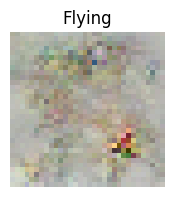

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 850ms/step - loss: 0.1040
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1451
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1273
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1322
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1345
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0984
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1354
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1130
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1106
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0856
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1310
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1516
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1165
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1260
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss

Sampling sprite: 500it [00:21, 22.77it/s]                         


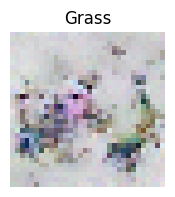

31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 832ms/step - loss: 0.1165
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1140
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0881
Epoch 43/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1051
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0927
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0923
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1453
Epoch 47/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1790
Epoch 48/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1619
Epoch 49/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1082
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1169
Epoch 51/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1199
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1394
Epoch 53/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1128
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss

Sampling sprite: 500it [00:22, 22.60it/s]                         


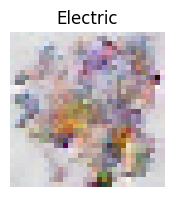

31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 838ms/step - loss: 0.1511
Epoch 61/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1237
Epoch 62/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0634
Epoch 63/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1098
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1333
Epoch 65/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1790
Epoch 66/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1950
Epoch 67/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0978
Epoch 68/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1146
Epoch 69/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1240
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0784
Epoch 71/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0895
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1196
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0796
Epoch 74/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss

Sampling sprite: 500it [00:22, 22.06it/s]                         


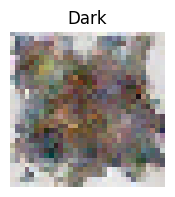

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 856ms/step - loss: 0.1440
Epoch 81/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0964
Epoch 82/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1306
Epoch 83/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1351
Epoch 84/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1573
Epoch 85/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1607
Epoch 86/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1582
Epoch 87/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.2176
Epoch 88/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1163
Epoch 89/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1332
Epoch 90/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1176
Epoch 91/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1141
Epoch 92/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1129
Epoch 93/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1295
Epoch 94/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss

Sampling sprite: 500it [00:22, 21.80it/s]                         


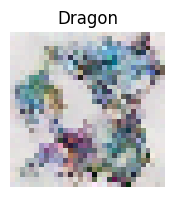

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 865ms/step - loss: 0.1311


In [7]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 20)])

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1499
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1284
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0958
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1516
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1367
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1392
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1108
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1497
Epoch 9/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1830
Epoch 10/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0906
Epoch 11/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0612
Epoch 12/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0797
Epoch 13/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1083
Epoch 14/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0654
Epoch 15/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - lo

Sampling sprite: 500it [00:22, 21.91it/s]                         


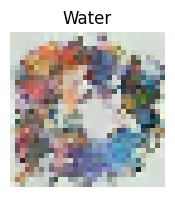

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 861ms/step - loss: 0.1275
Epoch 21/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1203
Epoch 22/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1113
Epoch 23/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1603
Epoch 24/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1032
Epoch 25/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0861
Epoch 26/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1011
Epoch 27/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1548
Epoch 28/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1148
Epoch 29/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0931
Epoch 30/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1152
Epoch 31/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0727
Epoch 32/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1588
Epoch 33/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1228
Epoch 34/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss

Sampling sprite: 500it [00:22, 21.96it/s]                         


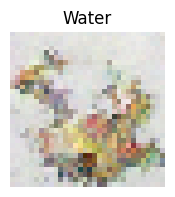

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 859ms/step - loss: 0.1123
Epoch 41/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1170
Epoch 42/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1056
Epoch 43/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0686
Epoch 44/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0625
Epoch 45/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1567
Epoch 46/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1004
Epoch 47/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0900
Epoch 48/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1100
Epoch 49/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0809
Epoch 50/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0943
Epoch 51/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1072
Epoch 52/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0753
Epoch 53/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1311
Epoch 54/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss

Sampling sprite: 500it [00:22, 22.08it/s]                         


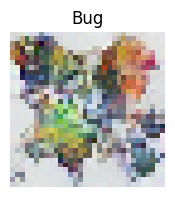

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 856ms/step - loss: 0.1115
Epoch 61/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1047
Epoch 62/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1009
Epoch 63/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0739
Epoch 64/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1096
Epoch 65/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1141
Epoch 66/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0826
Epoch 67/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0939
Epoch 68/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0628
Epoch 69/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1270
Epoch 70/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1524
Epoch 71/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1662
Epoch 72/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0888
Epoch 73/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0977
Epoch 74/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss

Sampling sprite: 500it [00:22, 21.80it/s]                         


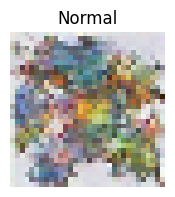

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 865ms/step - loss: 0.1350
Epoch 81/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0957
Epoch 82/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0964
Epoch 83/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0968
Epoch 84/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0976
Epoch 85/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0680
Epoch 86/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1020
Epoch 87/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0839
Epoch 88/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1239
Epoch 89/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1081
Epoch 90/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0717
Epoch 91/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1137
Epoch 92/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0767
Epoch 93/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0761
Epoch 94/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss

Sampling sprite: 500it [00:22, 21.96it/s]                         


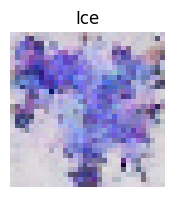

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 859ms/step - loss: 0.1012
Epoch 101/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1422
Epoch 102/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1428
Epoch 103/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0898
Epoch 104/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0868
Epoch 105/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0650
Epoch 106/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1063
Epoch 107/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1280
Epoch 108/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0747
Epoch 109/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0883
Epoch 110/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1101
Epoch 111/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0885
Epoch 112/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0969
Epoch 113/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0846
Epoch 114/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86

Sampling sprite: 500it [00:23, 21.67it/s]                         


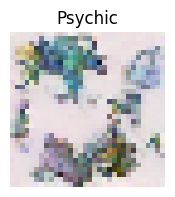

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 869ms/step - loss: 0.1471
Epoch 121/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0790
Epoch 122/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0828
Epoch 123/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0884
Epoch 124/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0694
Epoch 125/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0872
Epoch 126/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1569
Epoch 127/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1983
Epoch 128/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1239
Epoch 129/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0940
Epoch 130/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1091
Epoch 131/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1279
Epoch 132/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1296
Epoch 133/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1341
Epoch 134/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86

Sampling sprite: 500it [00:23, 21.51it/s]                         


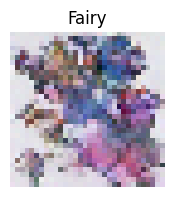

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 875ms/step - loss: 0.0923
Epoch 141/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1082
Epoch 142/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1404
Epoch 143/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1007
Epoch 144/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0765
Epoch 145/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1316
Epoch 146/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1204
Epoch 147/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0692
Epoch 148/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1004
Epoch 149/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0813
Epoch 150/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1285
Epoch 151/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1437
Epoch 152/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1021
Epoch 153/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0907
Epoch 154/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86

Sampling sprite: 500it [00:23, 21.12it/s]                         


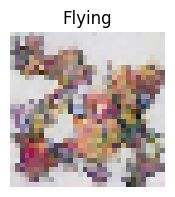

31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 890ms/step - loss: 0.0933
Epoch 161/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0809
Epoch 162/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0610
Epoch 163/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0743
Epoch 164/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1351
Epoch 165/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1205
Epoch 166/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1152
Epoch 167/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0922
Epoch 168/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1307
Epoch 169/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1636
Epoch 170/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1198
Epoch 171/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0943
Epoch 172/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1070
Epoch 173/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1005
Epoch 174/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86

Sampling sprite: 500it [00:23, 21.19it/s]                         


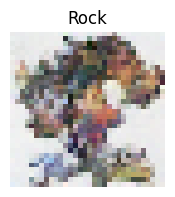

31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 888ms/step - loss: 0.0700
Epoch 181/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1271
Epoch 182/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1479
Epoch 183/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0718
Epoch 184/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1642
Epoch 185/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1000
Epoch 186/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0935
Epoch 187/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0881
Epoch 188/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1364
Epoch 189/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0538
Epoch 190/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1075
Epoch 191/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.1053
Epoch 192/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1036
Epoch 193/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0987
Epoch 194/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86

Sampling sprite: 500it [00:23, 21.15it/s]                         


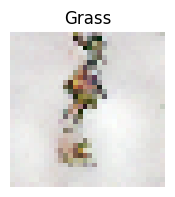

31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 889ms/step - loss: 0.0937
Epoch 201/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1352
Epoch 202/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0973
Epoch 203/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0982
Epoch 204/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0740
Epoch 205/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0763
Epoch 206/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0941
Epoch 207/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0740
Epoch 208/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0955
Epoch 209/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0826
Epoch 210/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0715
Epoch 211/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0910
Epoch 212/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0781
Epoch 213/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0578
Epoch 214/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86

Sampling sprite: 500it [00:23, 21.46it/s]                         


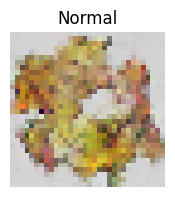

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 877ms/step - loss: 0.0850
Epoch 221/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0996
Epoch 222/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1070
Epoch 223/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0871
Epoch 224/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0689
Epoch 225/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0480
Epoch 226/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0719
Epoch 227/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0961
Epoch 228/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1010
Epoch 229/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1469
Epoch 230/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1022
Epoch 231/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0853
Epoch 232/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0760
Epoch 233/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0873
Epoch 234/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86

Sampling sprite: 500it [00:23, 21.47it/s]                         


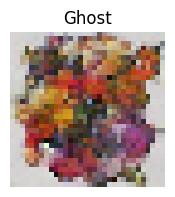

31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 879ms/step - loss: 0.0973
Epoch 241/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0637
Epoch 242/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0987
Epoch 243/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0979
Epoch 244/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1071
Epoch 245/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0708
Epoch 246/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1021
Epoch 247/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1416
Epoch 248/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0884
Epoch 249/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1141
Epoch 250/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0418
Epoch 251/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1041
Epoch 252/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0700
Epoch 253/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0702
Epoch 254/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87

Sampling sprite: 500it [00:24, 20.28it/s]                         


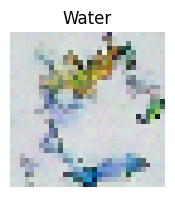

31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 925ms/step - loss: 0.1100
Epoch 261/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1170
Epoch 262/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1029
Epoch 263/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0808
Epoch 264/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0779
Epoch 265/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0950
Epoch 266/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0665
Epoch 267/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0799
Epoch 268/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1112
Epoch 269/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0584
Epoch 270/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0627
Epoch 271/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1265
Epoch 272/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0881
Epoch 273/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1385
Epoch 274/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86

Sampling sprite: 500it [00:23, 20.86it/s]                         


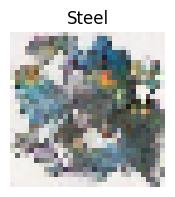

31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 900ms/step - loss: 0.1094
Epoch 281/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1277
Epoch 282/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0916
Epoch 283/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1344
Epoch 284/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0643
Epoch 285/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1029
Epoch 286/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1006
Epoch 287/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1060
Epoch 288/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0868
Epoch 289/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0728
Epoch 290/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0743
Epoch 291/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1146
Epoch 292/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0928
Epoch 293/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1047
Epoch 294/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86

Sampling sprite: 500it [00:23, 21.11it/s]                         


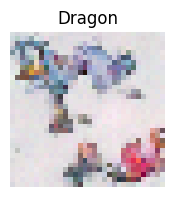

31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 892ms/step - loss: 0.1206
Epoch 301/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.1316
Epoch 302/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1208
Epoch 303/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1027
Epoch 304/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0859
Epoch 305/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1186
Epoch 306/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0566
Epoch 307/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1183
Epoch 308/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1116
Epoch 309/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0578
Epoch 310/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1000
Epoch 311/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0864
Epoch 312/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0654
Epoch 313/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0780
Epoch 314/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86

Sampling sprite: 500it [00:23, 21.51it/s]                         


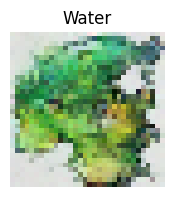

31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 878ms/step - loss: 0.1305
Epoch 321/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1080
Epoch 322/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0967
Epoch 323/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1016
Epoch 324/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1005
Epoch 325/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1299
Epoch 326/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1067
Epoch 327/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0708
Epoch 328/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0878
Epoch 329/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1486
Epoch 330/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0621
Epoch 331/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0617
Epoch 332/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0635
Epoch 333/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0633
Epoch 334/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86

Sampling sprite: 500it [00:23, 21.72it/s]                         


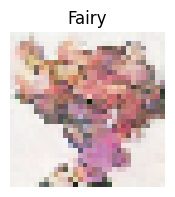

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 869ms/step - loss: 0.1006
Epoch 341/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0726
Epoch 342/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0860
Epoch 343/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1100
Epoch 344/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1106
Epoch 345/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0965
Epoch 346/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1259
Epoch 347/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0938
Epoch 348/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1253
Epoch 349/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1077
Epoch 350/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0704
Epoch 351/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1243
Epoch 352/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0692
Epoch 353/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0920
Epoch 354/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88

Sampling sprite: 500it [00:24, 20.43it/s]                         


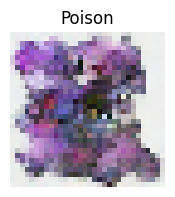

31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 923ms/step - loss: 0.1011
Epoch 361/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0576
Epoch 362/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1235
Epoch 363/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1179
Epoch 364/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1218
Epoch 365/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1031
Epoch 366/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1775
Epoch 367/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1077
Epoch 368/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1279
Epoch 369/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1117
Epoch 370/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0965
Epoch 371/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1028
Epoch 372/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0592
Epoch 373/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0813
Epoch 374/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86

Sampling sprite: 500it [00:23, 21.05it/s]                         


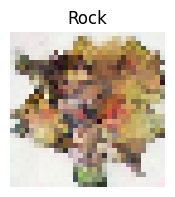

31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 894ms/step - loss: 0.0861
Epoch 381/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0596
Epoch 382/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0728
Epoch 383/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0778
Epoch 384/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0891
Epoch 385/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0702
Epoch 386/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1086
Epoch 387/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1280
Epoch 388/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1189
Epoch 389/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1171
Epoch 390/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0685
Epoch 391/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0818
Epoch 392/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1159
Epoch 393/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0647
Epoch 394/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86

Sampling sprite: 500it [00:23, 21.46it/s]                         


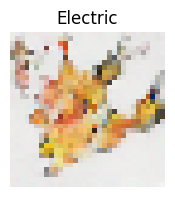

31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 879ms/step - loss: 0.1029
Epoch 401/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0931
Epoch 402/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0858
Epoch 403/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0939
Epoch 404/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0580
Epoch 405/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1122
Epoch 406/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0622
Epoch 407/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1019
Epoch 408/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1030
Epoch 409/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0789
Epoch 410/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0750
Epoch 411/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1166
Epoch 412/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0701
Epoch 413/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0834
Epoch 414/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86

Sampling sprite: 500it [00:23, 21.42it/s]                         


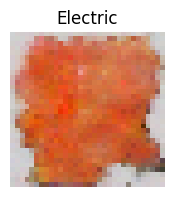

31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 881ms/step - loss: 0.1412
Epoch 421/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0815
Epoch 422/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0907
Epoch 423/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0599
Epoch 424/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0546
Epoch 425/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0837
Epoch 426/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0649
Epoch 427/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0910
Epoch 428/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0902
Epoch 429/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0592
Epoch 430/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0815
Epoch 431/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0820
Epoch 432/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0618
Epoch 433/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0612
Epoch 434/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86

Sampling sprite: 500it [00:23, 21.34it/s]                         


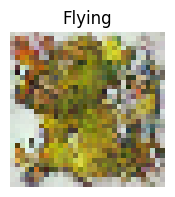

31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 884ms/step - loss: 0.0806
Epoch 441/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1241
Epoch 442/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0999
Epoch 443/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1399
Epoch 444/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1303
Epoch 445/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0842
Epoch 446/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1034
Epoch 447/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1343
Epoch 448/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0851
Epoch 449/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1424
Epoch 450/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1234
Epoch 451/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0797
Epoch 452/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1340
Epoch 453/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0671
Epoch 454/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86

Sampling sprite: 500it [00:23, 21.32it/s]                         


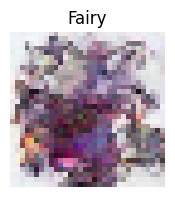

31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 885ms/step - loss: 0.1029
Epoch 461/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0806
Epoch 462/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1332
Epoch 463/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0788
Epoch 464/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1060
Epoch 465/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0810
Epoch 466/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0667
Epoch 467/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1068
Epoch 468/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1114
Epoch 469/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1012
Epoch 470/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0878
Epoch 471/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0797
Epoch 472/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1381
Epoch 473/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0773
Epoch 474/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86

Sampling sprite: 500it [00:23, 21.23it/s]                         


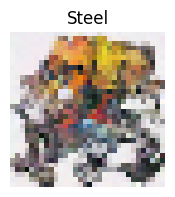

31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 888ms/step - loss: 0.0701
Epoch 481/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0609
Epoch 482/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0646
Epoch 483/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1008
Epoch 484/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1036
Epoch 485/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0995
Epoch 486/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0946
Epoch 487/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0809
Epoch 488/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0898
Epoch 489/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0689
Epoch 490/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0894
Epoch 491/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0913
Epoch 492/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0680
Epoch 493/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0921
Epoch 494/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86

Sampling sprite: 500it [00:23, 21.09it/s]                         


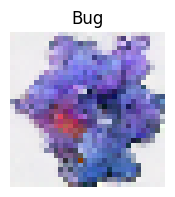

31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 893ms/step - loss: 0.0732


In [8]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=500, callbacks=[DiffusionCallback(model, 20)])

Generating sample 1/3


Sampling sprite: 500it [00:22, 22.59it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:22, 22.64it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:22, 22.12it/s]                         


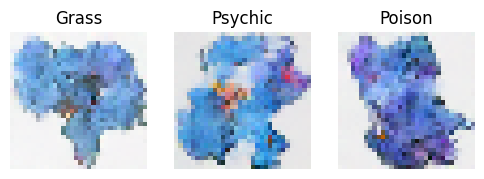

Generating sample 1/3


Sampling sprite: 500it [00:22, 22.42it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:21, 23.00it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:21, 22.82it/s]                         


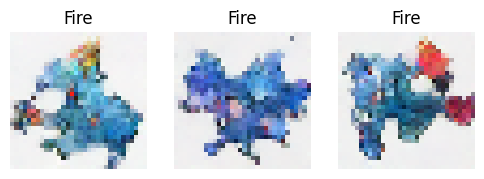

Generating sample 1/3


Sampling sprite: 500it [00:21, 22.92it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:22, 21.83it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:22, 21.98it/s]                         


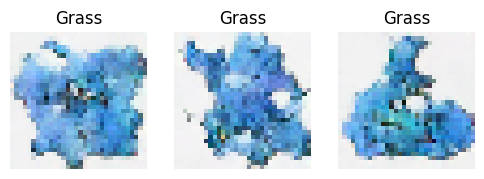

Generating sample 1/3


Sampling sprite: 500it [00:22, 22.35it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:22, 22.56it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:22, 22.62it/s]                         


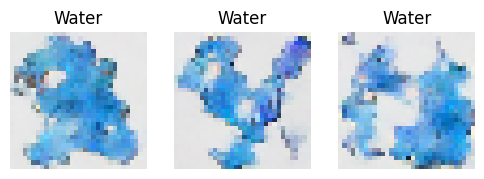

In [9]:
model.plot_samples(3)

model.plot_samples(3, "Fire")
model.plot_samples(3, "Grass")
model.plot_samples(3, "Water")

In [9]:
# import gradio as gr

# poke_diffusion = gr.Interface(
#     fn=model.plot_samples,
#     inputs=gr.Slider(minimum=1, maximum=10, label="Number of samples"),
#     outputs=gr.Image(),
# )

# poke_diffusion.launch(share=True)

## 2.2. Save Model

Finalmente, se guardan los resultados finales del modelo de difusión en un fichero `.h5` para su posterior uso y visualización. TODO: MIRAR OTROS FORMATOS DE GUARDADO

TODO: INVESTIGAR OTROS FORMATOS DE GUARDADO (HDF5, PICKLE, ETC.)

In [10]:
# Save the model function
# =====================================================================
def save_model(model: tf.keras.models.Model, model_name: str) -> None:
    """Saves the model

    :param model: The model to save
    :param model_name: The name of the model
    :return: None
    """

    # Save the model
    model_dir = "./diffusion_models/models/"
    os.makedirs(model_dir, exist_ok=True)
    if not os.path.exists(os.path.join(model_dir, f"{model_name}.h5")):
        model.save(os.path.join(model_dir, f"{model_name}.h5"))
        print(f"Model {model_name}, saved successfully!")
    else:
        print(f"Model {model_name}, already exists!")

In [11]:
# Save the model
# model_name = f"diffusion_{IMG_SIZE}_{BATCH_SIZE}_{EPOCHS}_{T}_{scheduler}_ddpm"

# save_model(model, model_name)

[BACK TO TOP](#top)